In [145]:
#!pip install tabulate

In [1]:
from tabulate import tabulate
import numpy as np
from numpy.random import choice
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit, ShuffleSplit, RandomizedSearchCV, KFold, StratifiedKFold, GroupKFold
from scipy.stats import randint as sp_randint

c:\users\alunb\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
class GroupStratifiedShuffleSplitBinary:
    """ A cross-validator (CV) object akin to sklearn's native GroupShuffleSplit or 
        StratifiedShuffleSplit where both groups AND stratification (currently only 
        with binary classification) are taken into account.
        
        target_var : the dataframe column which is the target to stratify by, 
        group_var  : the dataframe column which specifies the groups kept seperate
                     in training and test splits, 
        frac_train : fraction to put as CV train set (frac_test = 1 - frac_train)
        verbose    : provide textual feedback to user
        beta       : (see below) 
        max_evals  : (see below)
        n_splits   : number of splits to perform
        
        GroupStratifiedShuffleSplitBinary is initialized with group and target info,
        using this we create a 'group_table' which has the format:
        
                                n_target | n_entries | ratio <-------- i.e. imbalance of group
                             ===================================
            group_id (index)|            |           | 
                            |            |           |
                            |            |           |

        The subsequent .split method then creates a training and test set
        by randomly sampling groups from group_table with the goal that:

                (i)  the number of entries in train/test are approx equal to 
                     those defined by the specified train fraction 'frac_train'
                (ii) the ratio n_target/n_entries in train (and therefore test)
                     is approx equal to that ratio for the entire dataset

        Sampling from group_table continues until frac_train has been approx reached 
        (from below) OR until it has performed max_evals samples.
            
        Specifically, the train subset is formed by sampling from the group_table in
        such a way that the probability of choosing a given group is related to the 
        difference Delta, where 
            
            Delta := -([ratio-curr_train_imbalance] x sgn(curr_train_imbalance-data_set_imbalance))
        
        that is, when the current (partially filled) training set has a group 
        imbalance greater than that of the actual dataset we're sampling from, 
        groups with imbalance less than the current train imbalance are 
        preferentially selected (and vice versa). Concretely, the probabilty
        of next selecting group i to add to our training set is:
        
            P(i) = softmax(Delta(i) x beta)
        
        By sampling from the group_table we are guaranteed to have the desired
        property that groups are never mixed between train and test. However, we
        can't simply draw groups randomly, because we want a train set with the 
        same imbalance as the overall data set. This probabalistic method of 
        choosing means that the partial training set's imbalance oscillates, 
        hopefully converging on the desired (i.e. data set) imbalance.
        
        This can have the downside that groups with extreme values of imbalance
        (high or low) are preferentially chosen. It is therefore necessary to
        modify the parameter beta to find a satisfactory balance between groups
        being uniformly selected, and the training set being stratified (e.g.
        by using the method test_make_one_group_stratified_shuffle_split).
        
        The fact that GroupStratifiedShuffleSplitBinary is initialized with 
        all required info makes it a bit different from the usual sklearn
        cross-validators. The result is that the split method returns train-test
        indeces even without input. But of course when called through an sklearn
        method e.g. RandomSearchCV().fit(X,y), the X and y must match to the data
        passed in to initialize GroupStratifiedShuffleSplitBinary.
        
    """
    
    def __init__(self, target_var, group_var, frac_train = 0.8, verbose = False, 
                 beta=100, max_evals = 1e6, n_splits = 3):
        """ target_var is the dataframe coloum which is the target, group_var is the 
            dataframe column which specifies the group, n_splits is number of splits to perform
        """
        
        self.target_var = target_var 
        self.group_var = group_var
        self.frac_train = frac_train
        self.n_splits = n_splits
        self.verbose = verbose
        self.beta = beta
        self.max_evals = max_evals
        # we'll often want to know the data set imbalance
        self.data_set_imbalance = np.sum(self.target_var==1)/len(self.target_var)
        if self.verbose:
            print('Created GroupStratifiedShuffleSplit object for stratified splitting of binary class data with groups.')
            print('Total df entries = {}, total groups = {}, N(y=0)/(N(y=0)+N(y=1)) = {:.4f}'.format(
                len(self.target_var),
                len(self.group_var.unique()),
                self.data_set_imbalance
            ))
        # make the group table we'll use for sampling
        self.make_group_table()
        # train_groups and test groups are lists of group labels for train and test
        self.train_groups = []
        self.test_groups = []
    
    def __iter__(self):
        return self
    
    def __next__(self):
        result = self.split()
        return result
    
    def make_group_table(self):
        """ make a pandas table with info on each group which will be used later
        """
        
        self.group_table = pd.DataFrame({'group_id':self.group_var,
             'flag':self.target_var}).groupby('group_id').agg(['sum', 'count'])
        self.group_table.columns = self.group_table.columns.droplevel()
        self.group_table.rename(columns={'sum':'n_target', 'count':'n_entries'}, inplace=True)
        self.group_table['ratio'] = self.group_table['n_target']/self.group_table['n_entries']
        # make a numpy version with columns [ group_id | n_target | n_entries | ratio ]
        self.group_numpyarray = self.group_table.reset_index().values
        if self.verbose:
            print('Generated group_table')
        
    def make_one_group_stratified_shuffle_split(self):
        """ Given a numpy 'group_numpyarray' which has columns:
            [ group_id | n_target | n_entries | ratio ], make a 
            train test split in the manner described in the docstring
                                
        """

        # choose group at random to kick things off
        train_groups = [choice(self.group_numpyarray[:,0])]
        curr_train_frac = np.sum(self.group_numpyarray[np.isin(self.group_numpyarray[:,0],train_groups),2])/np.sum(self.group_numpyarray[:,2])
        curr_train_imbalance = np.sum(self.group_numpyarray[np.isin(self.group_numpyarray[:,0],train_groups),1])/np.sum(self.group_numpyarray[np.isin(self.group_numpyarray[:,0],train_groups),2])

        iterator = 0
        while (curr_train_frac < self.frac_train) & (iterator<=self.max_evals): # 

            if self.verbose:
                print('(Step {}) Train fraction = {:.4f}, Train imbalance = {:.4f} (full set = {:.4f})'.format(iterator,
                                                                                                           curr_train_frac, 
                                                                                                           curr_train_imbalance, 
                                                                                                           self.data_set_imbalance))
            # calculate preference for choosing next customer (boltz dist)
            next_choice_vec = -1.0*(self.group_numpyarray[~np.isin(self.group_numpyarray[:,0], train_groups), 3]-curr_train_imbalance)*np.sign(curr_train_imbalance-self.data_set_imbalance)
            next_choice_vec = np.array(next_choice_vec, dtype=np.float64)
            boltz_prob = np.exp(next_choice_vec*self.beta)/np.sum(np.exp(next_choice_vec*self.beta))
            # now make choice
            train_groups = np.append(train_groups, choice(self.group_numpyarray[~np.isin(self.group_numpyarray[:,0], train_groups), 0], p = boltz_prob))
            # calculate updated properties
            curr_train_frac = np.sum(self.group_numpyarray[np.isin(self.group_numpyarray[:,0],train_groups),2])/np.sum(self.group_numpyarray[:,2])
            curr_train_imbalance = np.sum(self.group_numpyarray[np.isin(self.group_numpyarray[:,0],train_groups),1])/np.sum(self.group_numpyarray[np.isin(self.group_numpyarray[:,0],train_groups),2])
            iterator = iterator +1 

        # test set is then anything not in train set
        test_groups = self.group_numpyarray[~np.isin(self.group_numpyarray[:,0], train_groups), 0]

        if self.verbose:
            if iterator == self.max_evals:
                print('\nExited having reached max number of evaluations ({})'.format(self.max_evals))
            else:
                print('\nCompleted succesfully with:')
                print('Train fraction = {:.4f}, Train imbalance = {:.4f} (full set = {:.4f})'.format(curr_train_frac, 
                                                                                                         curr_train_imbalance, 
                                                                                                         self.data_set_imbalance))

                curr_test_frac = np.sum(self.group_numpyarray[~np.isin(self.group_numpyarray[:,0],train_groups),2])/np.sum(self.group_numpyarray[:,2])
                curr_test_imbalance = np.sum(self.group_numpyarray[~np.isin(self.group_numpyarray[:,0],train_groups),1])/np.sum(self.group_numpyarray[~np.isin(self.group_numpyarray[:,0],train_groups),2])

                print('Test fraction = {:.4f}, Test imbalance = {:.4f} (full set = {:.4f})'.format(curr_test_frac, 
                                                                                                       curr_test_imbalance, 
                                                                                                       self.data_set_imbalance))
                print('|Train_groups| = {}, |Test_groups| = {}'.format(len(train_groups), len(test_groups)))
        
        self.train_groups = train_groups
        self.test_groups = test_groups
        self.curr_train_frac = curr_train_frac
        self.curr_train_imbalance = curr_train_imbalance

    def split(self, X=[], y=[], groups = None):
        """ Return indices of train and test splits
        """
        
        for isplit in range(self.n_splits):
            # make a train test split
            self.make_one_group_stratified_shuffle_split()
            # get the appropriate indices
            
            train_indx = self.group_var[self.group_var.isin(self.train_groups)].index
            test_indx = self.group_var[self.group_var.isin(self.test_groups)].index
            # N.B. sklearn wants positional locations (iloc)! Not indices (loc)!
            # they also must be numoy arrays so that they have a "flag" property
            train_indx = np.array([self.group_var.index.get_loc(idx) for idx in train_indx])
            test_indx = np.array([self.group_var.index.get_loc(idx) for idx in test_indx])
            
            
            yield train_indx, test_indx
        
    def get_n_splits(self, X, y, groups = None):
        return self.n_splits

    
    def test_make_one_group_stratified_shuffle_split(self, iterations = 100):
        """ make a plot to see how well make_one_group_stratified_shuffle_split is shuffling
            the groups
        """
        
        t1 = time()
        self.make_one_group_stratified_shuffle_split()
        train_group_multiple = self.train_groups.copy()
        stratification_arr = [self.curr_train_imbalance]
        for l in range(iterations-1):
            self.make_one_group_stratified_shuffle_split()
            train_group_multiple = np.append(train_group_multiple, self.train_groups)
            stratification_arr = np.append(stratification_arr, self.curr_train_imbalance)
        
        train_group_multiple.sort()
        count_groups=Counter(train_group_multiple)
        fig, ax = plt.subplots(figsize=[32, 16])
        ax.bar(x = np.arange(len(count_groups)), height=[count_groups[count] for count in count_groups], color = np.array([95, 75, 139])/255)
        ax.set_xticks(np.arange(len(count_groups)))
        ax.set_xticklabels([group for group in count_groups], rotation = 90)
        
        ax_r = ax.twinx()
        ax_r.scatter(np.arange(len(count_groups)), self.group_table.loc[self.group_table.index.isin([group for group in count_groups])].sort_index().ratio, color = np.array([228, 93, 191])/255)
        ax_r.set_ylabel('N(y=0)/(N(y=0)+N(y=1))')
        ax.set_title('n_iterations = {}, train_frac = {}, beta = {}'.format(iterations, self.frac_train, self.beta))
        ax.set_ylabel('n_times occurred in training set')
        ax.set_xlim(-1, len(count_groups))
        plt.show()
        
        print('Stratification = {:.4f} +/- {:.4f} (target = {:.4f})'.format(np.mean(stratification_arr), np.std(stratification_arr), self.data_set_imbalance))
        print('(Time taken for calcualtion = {:.2}s)'.format((time()-t1)))

# the following aren't codes related to the splitter itself, but are required to run the example
def went_to_top_uni_TF(poly_params, df, imbalance, final_year_arr, change_year_factor, noise):
    """ Calculate Boolean indicator
    """
    
    non_linear_model = (poly_params[0]*(df.weight_kg**poly_params[1])+poly_params[2]*(df.height_cm**poly_params[3])+poly_params[4]*(df.iq**poly_params[5]))*(df['final_year'].apply(lambda x: dict(zip(final_year_arr, change_year_factor))[x]))
    non_linear_model_noisy = non_linear_model + np.random.normal(0, np.std(non_linear_model)*noise, len(non_linear_model))

    return non_linear_model_noisy>np.percentile(non_linear_model_noisy, (1-imbalance)*100)

def make_student_table(n_subjects, n_groups, imbalance, noise, yrly_std, poly_params = None):
    """ Make the student_table
    """
    
    final_year_arr = np.arange(datetime.today().year-n_groups, datetime.today().year)
    if len(final_year_arr) == 1:
        final_year_arr = final_year_arr+1
    
    change_year_factor = np.random.normal(1, yrly_std, n_groups)
    # poly params are of format [coeff_1, exponent_1, coeff_2, exponent_2, ...]
    exp_lims = [-2, 2]
    coeff_lims = [-10, 10]
    
    if poly_params is None:
        poly_params = [
                        np.random.random()*(coeff_lims[1]-coeff_lims[0])+coeff_lims[0], np.random.random()*(exp_lims[1]-exp_lims[0])+exp_lims[0], 
                        np.random.random()*(coeff_lims[1]-coeff_lims[0])+coeff_lims[0], np.random.random()*(exp_lims[1]-exp_lims[0])+exp_lims[0],
                        np.random.random()*(coeff_lims[1]-coeff_lims[0])+coeff_lims[0], np.random.random()*(exp_lims[1]-exp_lims[0])+exp_lims[0]
                      ]

    name_array = pd.read_csv("./data/baby-names.csv", header = 0).name.values
    student_df = pd.DataFrame(data = {  'name' : np.random.choice(name_array, n_subjects),
                                        'weight_kg' : np.random.normal(50, 10, n_subjects),
                                        'height_cm' : np.random.normal(130, 30, n_subjects),
                                        'iq' : np.random.normal(100, 20, n_subjects),
                                        'final_year' : np.random.choice(final_year_arr, n_subjects),
                                      })

    # calculate indicator
    student_df['went_to_top_uni'] = went_to_top_uni_TF(poly_params, student_df, imbalance, final_year_arr, change_year_factor, noise)
    
    return student_df, poly_params
  
def plot_hyper_parameter_search_result(random_search_result, title = '', pyplot_ax = None, pyplot_fig = None):
    """ Given a random search object (e.g. created by the function do_random_hyper_parameter_search),
        plot model score as function of iterations
    """
    
    plt.rcParams.update({'font.size': 14})
    
    if pyplot_ax is None:
        fig, ax = plt.subplots(1,1, figsize = [8,8])
    else:
        ax = pyplot_ax
        fig = pyplot_fig
    
    iter_dat = random_search_result.cv_results_['mean_test_score']
    dashbest = max(iter_dat)
    ax.plot(range(0, len(iter_dat)), np.repeat(dashbest, len(iter_dat)), '--', c='xkcd:light green')
    ax.scatter(range(0, len(iter_dat)), iter_dat, c='xkcd:purple', s = 50)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Area under precision-recall curve')
    ax.set_title(title)
    
    plt.show()
    display(fig)
    
def plot_multiple_hyperplots(result_dict):
    """ result_dict is a dictionary {title for result: result object, ...}
    """
    
    
    # see what the axis limits will be
    y_ax_lims = np.array([])
    for result in result_dict:
        y_ax_lims = np.append(y_ax_lims, result_dict[result].cv_results_['mean_test_score'])
        y_ax_lims= [np.min(y_ax_lims), np.max(y_ax_lims)]
    
    y_ax_lims = [np.floor(y_ax_lims[0]*10)/10, np.ceil(y_ax_lims[1]*10)/10]
    
    fig, ax = plt.subplots(1,len(result_dict), figsize = [18,8])
    for idx, result in enumerate(result_dict):
        plot_hyper_parameter_search_result(result_dict[result], title = result, pyplot_ax = ax[idx], pyplot_fig = fig)
        ax[idx].set_ylim(y_ax_lims)
    
    plt.show()
    display(fig)

In [3]:
# number of students in dataset
n_subjects = 1000
# number of year groups (these will be our groups)
n_groups = 20
# how imbalanced is the data set? I.e. what fraction went to top uni
imbalance = 0.1
# put some noise in the generated data by adding samples from a gaussian with 
# mean 0 and std given by (noise x  std(calculated data))
noise = 0.1
# size of deviation between years -- scores from each year are multiplied 
# by a factor N(1, yrly_std)
yrly_std = 0.1

![alt text](yoydyne_data_science_logo.png "Yoydyne Data Science")


# Group Stratified Shuffle Split (Binary)

Before jumping into the specifics of this cross-validator, perhaps it's wise to remind ourselves why we use cross-validation when training our models, and to discuss which types of cross-validators are open to us. 

## Life without cross-validation

When presented with a dataset containing various features along with some target variable, typically our goal is not simply to fit a model leading to the lowest loss function on the dataset. Rather, we are interested in finding a model which will perform well on unseen data. For example, after training a model on some historical stock price data, we would most likely judge that model's success on how well it predicts tomorrow's stock prices, rather than the $R^2$ coefficient it acheived on historical data.

To this end, we typically segregate our data into train and test splits, where the former is used to train our model, and the latter is used to evaluate its performance. That is, the test split is data excluded from the training process for the explicit purpose of validating our model's generalizability. So far, so good. 

![alt text](fig_train_test_cubes.png "Train-test split")

However, within the three words *train our model* lies a great deal of detail, and so as the [saying goes](https://en.wikipedia.org/wiki/The_devil_is_in_the_detail), also lies, the devil. For, even if we restrict ourselves to a single algorithm, we still have a (usually infinite) number of models to choose from. Take for example a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), we could train a given forest with a specified number of trees, class weight, maximum tree depth etc. on our training data, and then ascertain it's performance by evaluating it on the test data. Now however, say we have a feeling that altering some properties of our random forest (e.g. increasing the number of trees), will improve the performance of our model. We can again train this new forest on our training set, and decide to keep it or stick with our previous random forest depending on how well each performed on our test data.

But why stop there? We could repeat the same process, performing a search over an entire hyper parameter space, by choosing points (e.g. on a grid or by random sampling) in that space, training a forest with those hyperparameters, and evaluating its performance on held-out test data. After searching over what we deem to be a sufficient number of hyperparameters, we'll just choose the model which scored best on the test data.

The problem however, is that in optimizing our model in such a manner, we have gone against our entire premise of splitting data into training and test; by holding out a portion of the data we were trying to ascertain how well a model would perform on unseen data, *but by refining hyperparameters on the test score we have unwittingly optimized a model which performs very well on the data we were given, and have no idea how it will generalize*. Essentially we have re-combined the train and test splits.

![alt text](fig_train_notest_cubes.png "Train and test no longer split")

## Cross-validation saves the day

Fortunately, cross-validation provides us with a solution to this problem. Though, as we will see, there are many cross-validators available to us as data scientists, they all work under the same basic premise; by (repeatedly) segregating the training data into a portion for testing and a portion for evaluating a model, we're able to compare various models, whilst reserving the test data for a final evaluation of the best performing model.

To make this concrete, we can consider 4-fold cross-validation, as shown diagramatically below

![alt text](fig_4_fold_cv.png "4-fold cross-validation")

Here, we split our data into 4-folds, train a model on three of the folds (white cubes), and evaluate it on the fourth (grey cubes). We carry out this procedure four times, and can estimate the model's test error by evaluating the average test error of these four trials. (As a technical aside, it is interesting to note that there exists no unbiased estimator of the variance of such a k-fold cross-validation [(Bengio and Grandvalet, 2004)](www.jmlr.org/papers/volume5/grandvalet04a/grandvalet04a.pdf)).

Using this procedure, we can happily perform our exploration of hyperparameter space, cross-validating at each point, computing a test error estimate from this, and selecting our best performing model. We can then evaluate this model on the held-out test data to give us an estimate of how well it will perform in the real world. 

## Cross-validators

There are a number of cross validators available to us as data scientists, here I'll review some of those provided by the `sklearn` library, loosely based on the summary shown here [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py).

For this example, we'll consider a generated dataset of 30 students, each student has a name, a year of graduation, and a boolean indicator showing whether they went on to study at university or not. The first 5 rows of the dataframe are as follows:

| name    | uni (y/n)   |   year |
|:--------|:------------|-------:|
| Teresa  | y           |   2014 |
| Cherrie | y           |   2014 |
| Jaden   | n           |   2014 |
| Adriana | n           |   2014 |
| Madalyn | n           |   2014 |

In [4]:
name_array = pd.read_csv("./data/baby-names.csv", header = 0).name.values
len_array = 30
names = np.random.choice(name_array,len_array)
school_year = np.concatenate([np.repeat('2014', len_array*0.4),np.repeat('2015', len_array*0.3),np.repeat('2016', len_array*0.3)])
went_to_uni = np.concatenate([np.repeat('y', np.ceil(len_array*0.4*0.1)), np.repeat('n', np.floor(len_array*0.4*0.9)),
np.repeat('y', np.ceil(len_array*0.3*0.2)), np.repeat('n', np.floor(len_array*0.3*0.8)),
np.repeat('y', np.ceil(len_array*0.3*0.2)), np.repeat('n', np.floor(len_array*0.3*0.8))])
student_df = pd.DataFrame(data = {'name':names, 'year':school_year, 'uni (y/n)':went_to_uni})
student_df.head()

,name,uni (y/n),year
0,Emmer,y,2014
1,Terrell,y,2014
2,Ulysses,n,2014
3,Maxie,n,2014
4,Phillip,n,2014


In [5]:
print(tabulate(student_df.set_index('name').head(), tablefmt="pipe", headers="keys"))

| name    | uni (y/n)   |   year |
|:--------|:------------|-------:|
| Emmer   | y           |   2014 |
| Terrell | y           |   2014 |
| Ulysses | n           |   2014 |
| Maxie   | n           |   2014 |
| Phillip | n           |   2014 |


We can also plot our dataset:

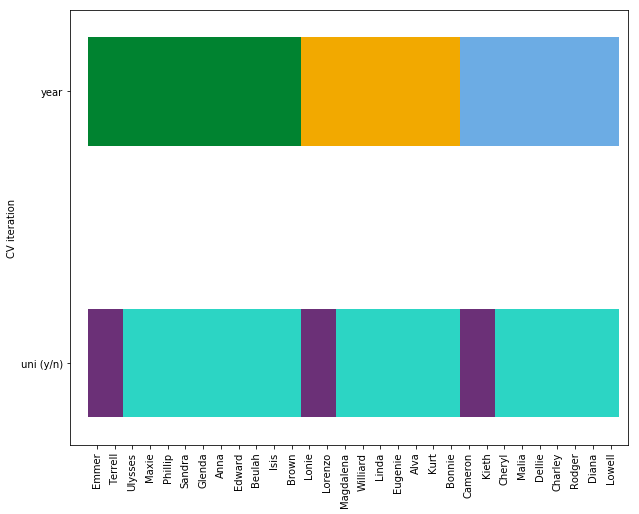

In [6]:
box_width = 0.4
c_arr = ['#0957C3',
         '#D14124',
         '#008330',
         '#F2A900',
         '#6B3077',
         '#2CD5C4',
        '#6CACE4']

fig, ax = plt.subplots(figsize = [10, 8])


for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))
            
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.3, 0.3])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,1))
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
ax.set_yticklabels(yticks)
plt.savefig('initial_data_plot.png', dpi = 300, bbox_inches = 'tight') #

plt.show()

Where the graduation year (<span style="color:#008330">2014</span>, <span style="color:#F2A900">2015</span>, <span style="color:#6CACE4">2016</span>) for each student and whether they went on to attend uni (<span style="color:#6B3077">yes</span>, <span style="color:#2CD5C4">no</span>) is noted.

### k-fold CV

Now let's see how different cross-validators partition this dataset. First of all we'll consider the k-fold cross validation described above, just as in that description, we'll use 4-folds.

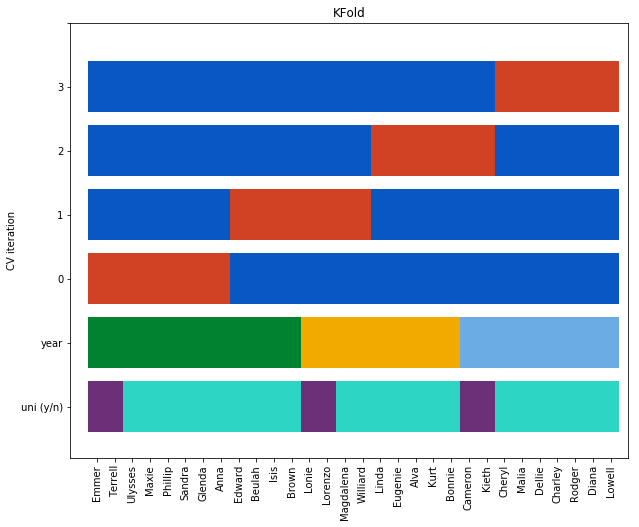

In [7]:
n_splits = 4

cv_iter = KFold(n_splits=n_splits).split(np.arange(0,len_array))

fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))
            
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('KFold')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
plt.savefig('k_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

As we can see, at each 1/k cross-validation iteration, a 1/k (i.e. a quarter in this example) of the data is held out for testing (shown in <span style="color:#D14124">red</span>) while the rest is used for training (shown in <span style="color:#0957C3">blue</span>).

The `year` and `uni (y/n)` are ignored in determining the train-test splits of the k-fold cross-validation, but we might imagine a situation where we'd like to take them into account. Perhaps we're training a model to predict which students will go on to study at university. As we can see, our dataset is very imbalanced with regards to this target variable. We'd like our training-test splits to reflect this. Luckily, `StratifiedKFold` does just that.

### Stratified k-fold

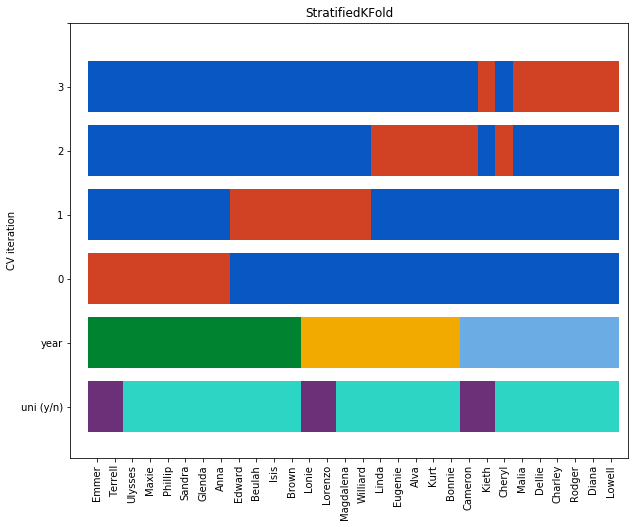

In [8]:
cv_iter = StratifiedKFold(n_splits=n_splits).split(np.arange(0,len_array),y=student_df['uni (y/n)'])


fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))     
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('StratifiedKFold')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
plt.savefig('k_stratified_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

We can see that the train-test splits reflect the stratification of the dataset with regards to the target variable `uni (y/n)` (though only approximately in this case as we have 6 `uni (y/n)=y` cases to split between 4 folds).

### Grouped k-fold

We might also want a k-fold stratifier that takes account of how our data is grouped, `GroupKFold` keeps groups separated from eachother in the train-test splits. In this case the group is graduation year, and we only have three such years, so only three splits are possible:

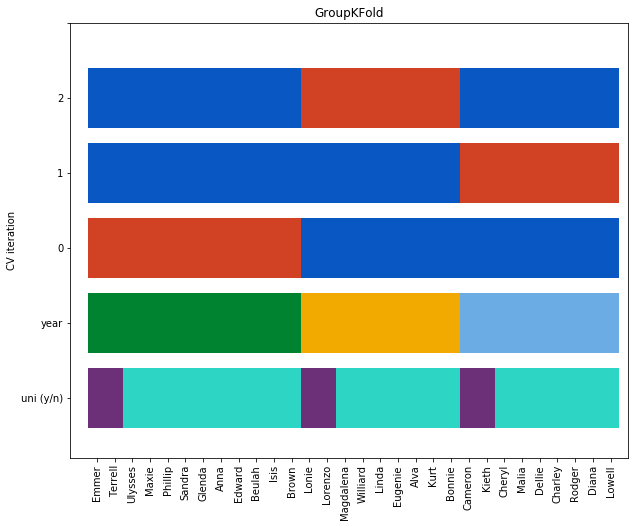

In [10]:
n_splits = 3
cv_iter = GroupKFold(n_splits=n_splits).split(np.arange(0,len_array),groups=student_df['year'])


fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))
            
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('GroupKFold')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
plt.savefig('k_grouped_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Beyond k-fold cross-validators

The previous classifiers use some form of k-fold methodology, where the dataset is split into k-times, and each data point (students in our example) appears in the testing split once, and the training split (k-1) times. These folds and splits are uniquely defined from the moment we choose our classifier. However, to imporve generalization we may want to randomly sample train and test groups from our data at each validation iteration. This will have the disadvantage, for example, that data points may pop-up multiple times in the test split. The flip side is that it will give us much more freedom in our cross-validation, e.g. we might choose a 9:1 train:test split to be run for 5 iterations, whereas running this ratio for k-fold validation would require 10 iterations, and therefore be twice as computationally expensive.

These types of cross-validators are denoted by the word "Shuffle" in `sklearn`, as they randomly shuffle the dataset before each cross-validations iteration. Let's look at how they apply to our example data.

### Shuffle Split

As described above, `ShuffleSplit` allows us to specify a test size (here it's 0.25, as before), and a number of iterations to perform (we choose 4)

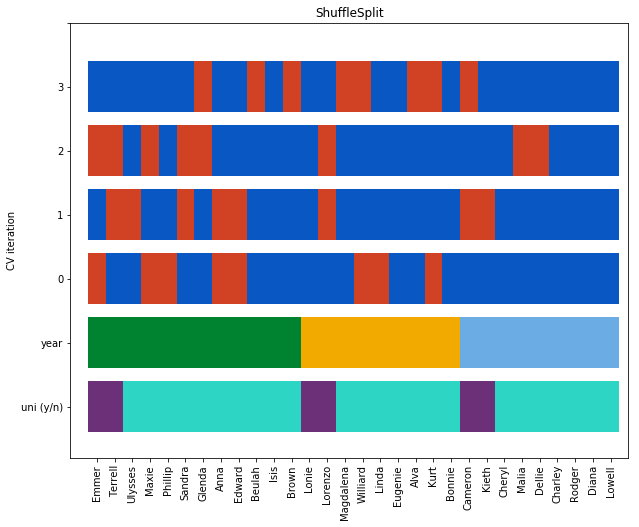

In [11]:
n_splits = 4
cv_iter = ShuffleSplit(n_splits=n_splits, test_size = 0.25).split(np.arange(0,len_array))


fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))            
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('ShuffleSplit')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
plt.savefig('shuffle_split_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

Note that due to the randomized nature, some students appear in the test split multiple times.

### Stratified Shuffle Split

`StratifiedShuffleSplit` takes account of the stratification of the entire dataset with regards to some target variable (which here is `uni (y/n)` again)

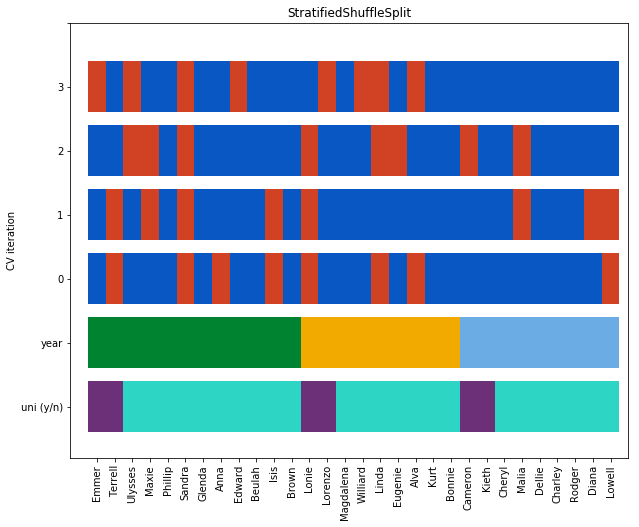

In [12]:
n_splits = 4
cv_iter = StratifiedShuffleSplit(n_splits=n_splits, test_size = 0.25).split(np.arange(0,len_array), y = student_df['uni (y/n)'])


fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))
            
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('StratifiedShuffleSplit')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
plt.savefig('strat_shuffle_split_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

### Group Shuffle Split

`GroupShuffleSplit` ignores the stratification of the dataset with regards to target variable, but ensures that different groups are seperated in training and testing (our groups here are the graduation years)

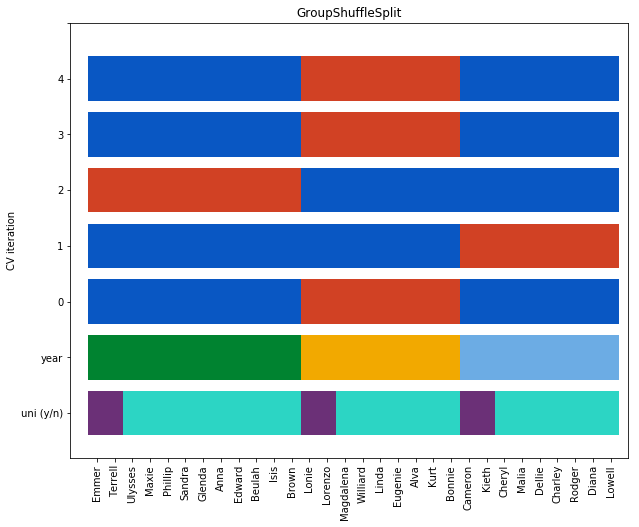

In [13]:
n_splits = 5
cv_iter = GroupShuffleSplit(n_splits=n_splits, test_size = 0.25).split(np.arange(0,len_array), groups = student_df['year'])


fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))
            
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('GroupShuffleSplit')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
plt.savefig('group_shuffle_split_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

Ok, so for 3 groups (school years in our case) the result is rather trivial, but we can see how this cross validator keeps groups seperated in train and test, doing this randomly with each CV iteration.

## Group Stratified Shuffle Split

Following the last two examples, we might expect the next cross-validator to follow would be one which captured the essence of its two predecesors. That is, a cross-validator which keeps groups seperated between train and test splits, as well as ensuring that the proportion of 'positive' or 'negative' samples (i.e. based on a defined target variable) in the train and test split (ensuring this is the case for either the train or test is clearly sufficient) are representative of the dataset as a whole (i.e. stratified).

### A (too) simple example

For our previous example, each group (school year) had the same proportion of students going on to study at university, therefore the `GroupStratifiedShuffleSplit` cross-validator performs similarly to `GroupShuffleSplit`:

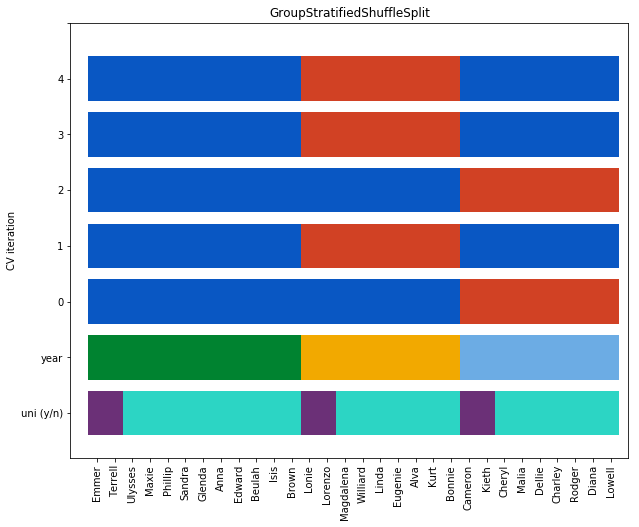

In [14]:
n_splits = 5

cv_iter = GroupStratifiedShuffleSplitBinary([np.int(x) for x in student_df['uni (y/n)'] == 'y'], student_df['year'], n_splits = n_splits, frac_train = 0.6).split()

fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(school_year):
        if yr == '2014':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[2],
                                          label = '2014'))
            
        if yr == '2015':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[3],
                                          label = '2015'))
        if yr == '2016':
            ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = c_arr[6],
                                          label = '2016'))
            
for subject, unibool in enumerate(went_to_uni):
        if unibool == 'y':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        if unibool == 'n':
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len_array))
ax.set_xticklabels(names, rotation = 90)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len_array])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('GroupStratifiedShuffleSplit')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
plt.savefig('group_stratified_shuffle_split_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

(N.B. We've specified a train-test split of 0.6:0.4, hence the first year group is never selected as a test set.)

### The Difficulty in splitting by Group and keeping things Stratified

In a more realistic scenario, each group will typically contain a different proportion of 'positive' and 'negative' (as defined by the target variable) samples. What we'd like is to specify a train:test ratio (e.g. 0.8:0.2), then let our cross-validator go ahead and sort the data into train and test portions, with each group being in either of (but not both) the train or test split, and the train and test split being representative of the entire data set with respect to the target variable (i.e. stratified). We can then state our requirements as follows; our `GroupStratifiedShuffleSplit` cross validator should adhere to the following conditions:

1. Each group occurs in either the test or train splits. The number of samples in train-test is specified as a ratio by the user, though we allow our cross validator to reach this ratio approximately, as the size of groups may make reaching an exact train-test split impossible. This is the `Group` part.

2. Both the train and test splits contain a proportion of 'positive' and 'negative' (as defined by the target variable) samples which is representative of the entire data set. We let our cross-validator be approximately representative as condition 1. already constrains the CV quite strongly. This is the `Stratified` part.

3. The train and test splits should be randomized on each iteration, otherwise we make redundant all the statistical merits of running multiple CV iterations. This is the `Shuffle` part.

If we simply let our cross-validator randomly choose a number of groups for the train and test splits which achieve the closest value possible of the desired train-test split (i.e. conditions 1 and 3 are satisfied), we have no guarantee that the train and test data will be correctly stratified (i.e. condition 2 is not satisfied). Moreover, if we simply constrain the validator to find the best train-test split under the constraint that groups cannot be split between train and test (i.e. conditions 1 and 2 are satisfied), we have a unique solution and get the same split each time (i.e. condition 3 is not satisfied).

### How we select samples for the training set

Here we'll go into detail about how we circumvent some of the problems raised in the previous section. We'll talk about forming the training set, the test set will then simply be formed of all the entries not used in the training set (we could equivalently build the test set in this manner, then form a training set from all entries not selected for the training set).

Firstly, we calculate some aggregates for all groups in our data, namely; the number of entries ($N_{entries}$), the number of those entries with target variable `= True` ($N_{target}$), and the proportion of target variable `= True` within the group ($N_{target}$/$N_{entries}$). This gives us a table which looks something like this:

![alt text](table_1.png "Aggregate table for groups appearing in data set")

Next we randomly select (without replacement) one group and add it (i.e. all entries belonging to that group) to the training set:

![alt text](table_2.png "Randomly select a single group")

The first thing to check now that we've begun contructing our training set is the ratio of train to test splits. The user specifies a ratio $R_{tt} := N_{test}/N_{train}$ and we want to get as close to that as possible, so we check that the current number of entries in our (under construction) training set, let's call it $N_{train,1}$ (it's simply = 45 in our example here), is sufficient. That is, if: 

$$\frac{N-N_{train,1}}{N_{train,1}} > R_{tt} $$

Then we must add further groups to our training set. Let's safely assume that for our ficticious dataset this is the case. Then we need to add some more entries, i.e. another group, to our training set. But which group should we choose? 

The stratified nature of the cross-validator means that we are constrained to have a class imbalance in our training set (approximately) equal to the class imbalance of the total data set. Let's call the total class imbalance, $I$, and the current (under construction) training set imbalance $I_{train,1}$ (it's = 0.178 in our example currently). When choosing a new group, we'd clearly like to make the choice such that the next iteration of our training set has an imbalance $I_{train,2}$ which is closer to $I$ than $I_{train,1}$ was. Simply put, if 


![alt text](table_3.png "Assign probabilities to all other groups")

In [70]:
student_df, poly_params = make_student_table(n_subjects, n_groups, imbalance, noise, yrly_std)
# n.b. names taken from https://github.com/hadley/data-baby-names/blob/master/baby-names.csv

# also make splits for training models 
X = student_df.drop(columns = ['name', 'final_year', 'went_to_top_uni'])
y = student_df['went_to_top_uni']

display(student_df.head(5))

,final_year,height_cm,iq,name,weight_kg,went_to_top_uni
0,2006,170.184438,110.955942,Russel,60.545741,False
1,2011,98.304732,104.386535,Oleta,46.376157,False
2,2011,148.420147,106.135499,Jocelyn,44.194137,False
3,2009,170.501573,102.839081,Verne,46.066820,False
4,2012,120.908337,80.411208,Antone,43.311403,False


In [74]:
yrs_in_table = student_df.sort_values('final_year')['final_year'].unique()

In [80]:
yrs_col = [plt.get_cmap('rainbow')(x) for x in np.arange(0, 1, 1./len(yrs_in_table))]

In [82]:
yr_col_dict = dict(zip(yrs_in_table, yrs_col))

In [89]:
yr_col_dict[2014]

(1.0, 0.7005430375932911, 0.37841105004231035, 1.0)

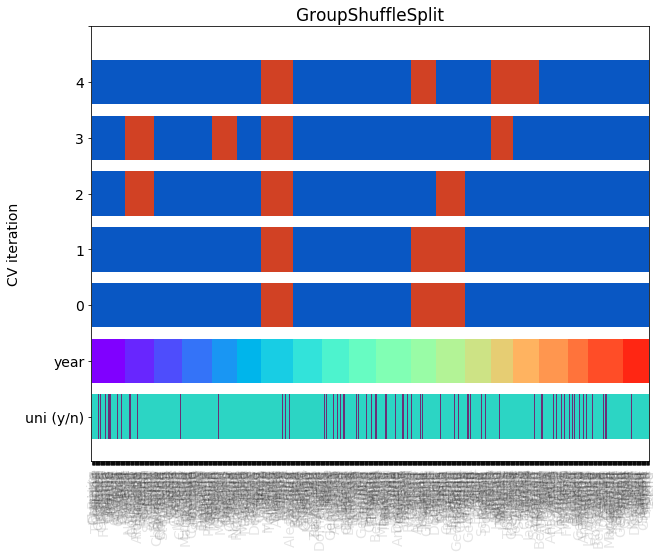

In [101]:
student_df = student_df.sort_values('final_year')

n_splits = 5
#cv_iter = GroupShuffleSplit(n_splits=n_splits, test_size = 0.25).split(np.arange(0,len_array), groups = student_df['year'])

cv_iter = GroupStratifiedShuffleSplitBinary(student_df['went_to_top_uni'].astype(int), student_df['final_year'], n_splits = n_splits, frac_train = 0.8).split()

fig, ax = plt.subplots(figsize = [10, 8])

box_width = 0.8

for subject, yr in enumerate(student_df['final_year']):
    ax.add_patch(patches.Rectangle((subject-0.5,0-box_width/2),1,box_width,facecolor = yr_col_dict[yr],
                                  label = str(yr)))

            
for subject, unibool in enumerate(student_df['went_to_top_uni']):
        if unibool:
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[4],
                                          label = 'y'))
        else:
            ax.add_patch(patches.Rectangle((subject-0.5,-1-box_width/2),1,box_width,facecolor = c_arr[5],
                                          label = 'n'))

for split in range(n_splits):
    single_fold = next(cv_iter)
    for idx, group in enumerate(single_fold):
        for subject in group:
            ax.add_patch(patches.Rectangle((subject-0.5,split+1-box_width/2),1,box_width,facecolor = c_arr[idx]))

ax.set_xticks(np.arange(0, len(student_df)))
ax.set_xticklabels(student_df['name'], rotation = 90, alpha = 0.1)
ax.set_ylim([-1.8, n_splits+0.8])
ax.set_xlim([-1.5,len(student_df)])
ax.set_yticks(np.arange(-1,n_splits+2))
ax.set_title('GroupShuffleSplit')
ax.set_ylabel('CV iteration')
yticks = ['uni (y/n)', 'year']
for n in range(n_splits): yticks.append(n)
ax.set_yticklabels(yticks)
#plt.savefig('group_stratified_shuffle_split_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [5]:
#import scipy as sp

In [39]:
clf = RandomForestClassifier(verbose=True,n_jobs=-1)

# and we'll do a search in hyper parameter space for the best params,
# here specify parameters and distributions to sample from
param_dist = {"n_estimators": sp_randint(10, 500),
              "max_depth": [3, None],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             'class_weight':[{1: w} for w in [1, 3, 10, 30, 50, 100,1000]]}

# run randomized search for a given number of iterations
n_iter_search = 50

# find best model scoring on area under precision recall curve, aka average precision
model_scoring = 'average_precision'

# params for the cross validators
number_of_cv_splits = 3
test_size = 0.33

# a few cross-validators to try:
sss = StratifiedShuffleSplit(n_splits = number_of_cv_splits, test_size = test_size)
gss = GroupShuffleSplit(n_splits = number_of_cv_splits, test_size = test_size)
# this is the cross validator we've made
gsssb = GroupStratifiedShuffleSplitBinary(y, student_df['final_year'], n_splits = number_of_cv_splits, frac_train = (1-test_size))

In [40]:
# StratifiedShuffleSplit
random_search_sss = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search,
                                   cv=sss, n_jobs=-1, scoring=model_scoring)
random_search_sss.fit(X, y, groups = student_df['final_year'])

# GroupShuffleSplit
random_search_gss = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search,
                                   cv=gss, n_jobs=-1, scoring=model_scoring)
random_search_gss.fit(X, y, student_df['final_year'])

# GroupStratifiedShuffleSplitBinary
random_search_gsssb = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search,
                                   cv=gsssb, n_jobs=-1, scoring=model_scoring)
random_search_gsssb.fit(X, y, student_df['final_year'])

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 236 out of 236 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 376 out of 376 | elapsed:    0.5s finished


RandomizedSearchCV(cv=<__main__.GroupStratifiedShuffleSplitBinary object at 0x000001D88C07CE80>,
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D88C07C5C0>, 'max_depth': [3, None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D88C07CB38>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D88C07C9B0>, 'bootstrap': [True, False],

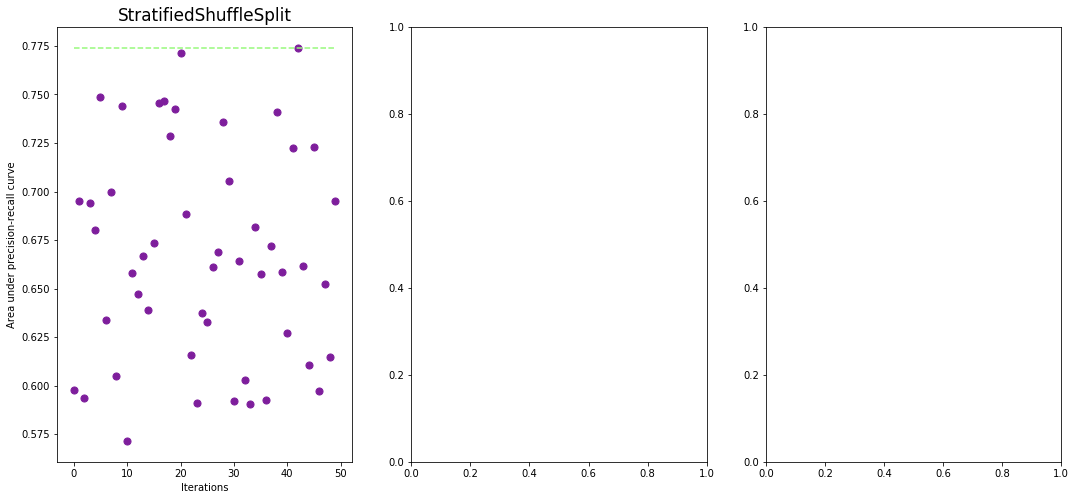

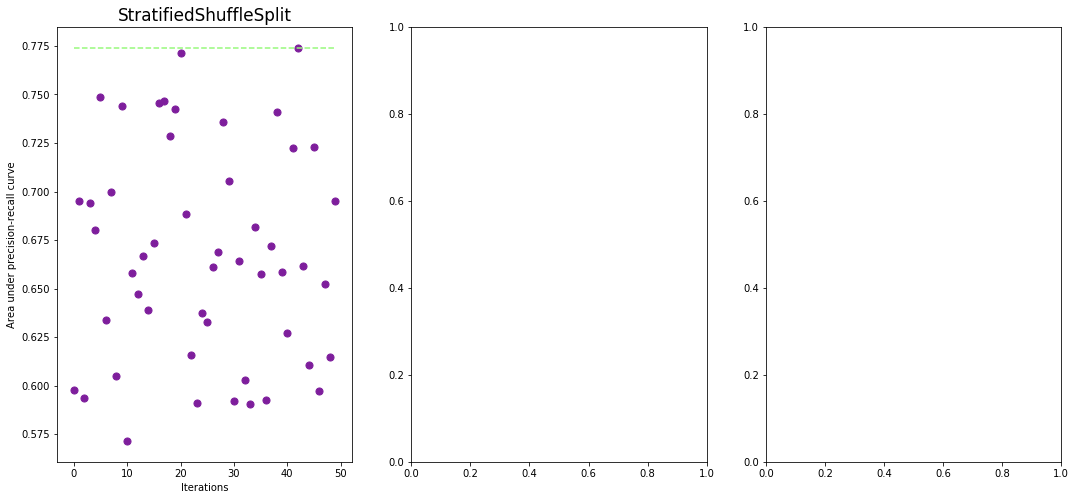

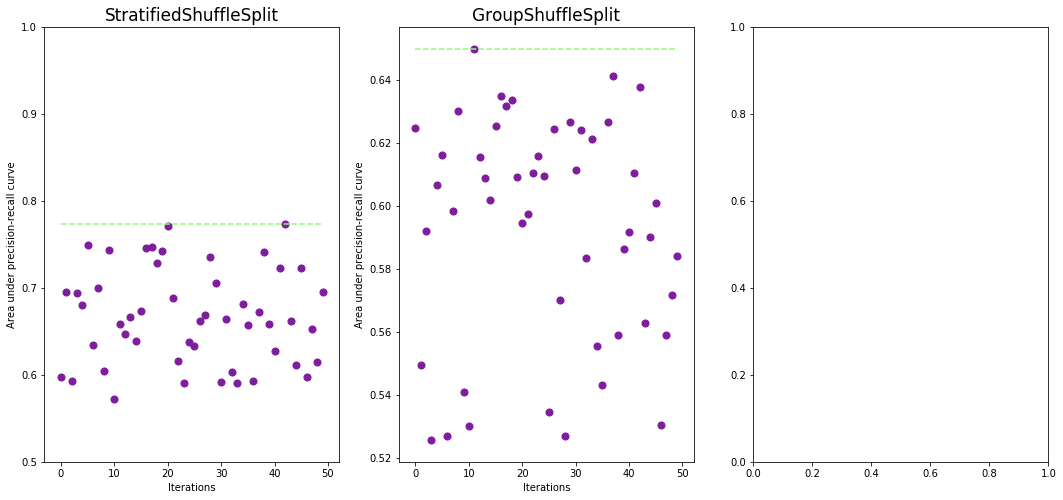

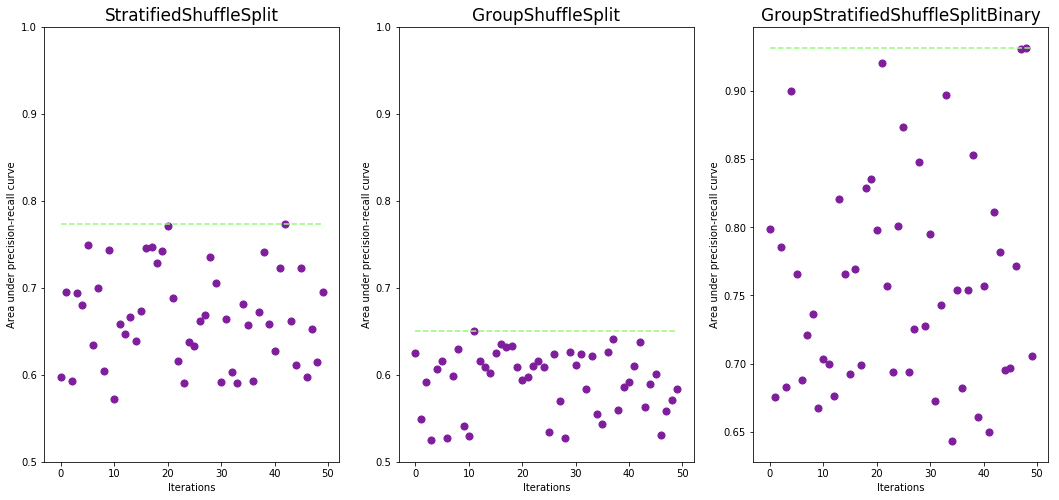

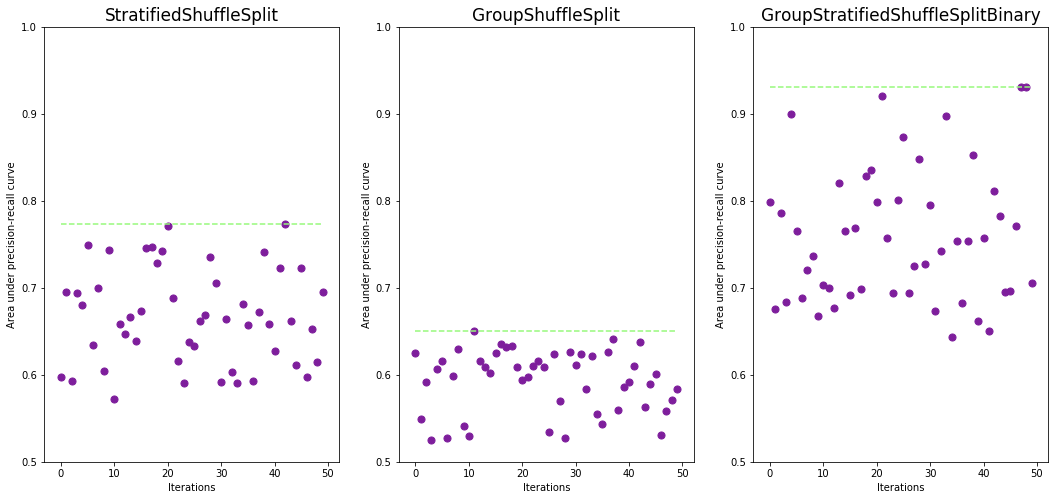

In [41]:
res_dict = {'StratifiedShuffleSplit': random_search_sss, 
            'GroupShuffleSplit' : random_search_gss,
           'GroupStratifiedShuffleSplitBinary' : random_search_gsssb}
plot_multiple_hyperplots(res_dict)

In [10]:
latest_student_df, poly_params = make_student_table(np.round(n_subjects/n_groups).astype(int), 1, imbalance, noise, yrly_std, poly_params)

In [29]:
# next year's data becomes available
latest_student_df = pd.DataFrame(data = {  'name' : np.random.choice(name_array, np.round(n_subjects/n_groups).astype(int)),
                                    'weight_kg' : np.random.normal(50, 10, np.round(n_subjects/n_groups).astype(int)),
                                    'height_cm' : np.random.normal(130, 30, np.round(n_subjects/n_groups).astype(int)),
                                    'iq' : np.random.normal(100, 20, np.round(n_subjects/n_groups).astype(int)),
                                    'final_year' : np.repeat(2019, np.round(n_subjects/n_groups).astype(int)),
                                  })

# calculate indicator
latest_student_df['went_to_top_uni'] = went_to_top_uni_TF(latest_student_df, imbalance, [2019], np.random.normal(1, yrly_std , 1))

NameError: name 'name_array' is not defined

In [12]:
latest_student_df.final_year = 2019

In [13]:
display(latest_student_df.head())

name,weight_kg,height_cm,iq,final_year,went_to_top_uni
Savion,57.23188081945343,144.4540726245911,79.36760257119153,2019,false
Jan,45.91034882648427,189.67932308272628,68.04962707290747,2019,true
Jeanie,52.728821266813654,120.3683491489435,115.61381307760516,2019,false
Julien,53.38460190346505,117.01500915362307,111.44682085086558,2019,false
Electa,45.38086327608676,47.40991385744178,116.94680693887314,2019,false


In [14]:
y_pred_gss = random_search_gss.best_estimator_.predict(latest_student_df.drop(columns = ['name', 'final_year', 'went_to_top_uni']))
y_pred_sss = random_search_sss.best_estimator_.predict(latest_student_df.drop(columns = ['name', 'final_year', 'went_to_top_uni']))
y_pred_gsssb = random_search_gsssb.best_estimator_.predict(latest_student_df.drop(columns = ['name', 'final_year', 'went_to_top_uni']))
# probabilities
y_prob_gss = random_search_gss.best_estimator_.predict_proba(latest_student_df.drop(columns = ['name', 'final_year', 'went_to_top_uni']))
y_prob_sss = random_search_sss.best_estimator_.predict_proba(latest_student_df.drop(columns = ['name', 'final_year', 'went_to_top_uni']))
y_prob_gsssb = random_search_gsssb.best_estimator_.predict_proba(latest_student_df.drop(columns = ['name', 'final_year', 'went_to_top_uni']))

[Parallel(n_jobs=8)]: Done 34 tasks | elapsed: 0.0s
[Parallel(n_jobs=8)]: Done 184 tasks | elapsed: 0.1s
[Parallel(n_jobs=8)]: Done 244 out of 244 | elapsed: 0.1s finished
[Parallel(n_jobs=8)]: Done 34 tasks | elapsed: 0.0s
[Parallel(n_jobs=8)]: Done 105 out of 105 | elapsed: 0.0s finished
[Parallel(n_jobs=8)]: Done 34 tasks | elapsed: 0.0s
[Parallel(n_jobs=8)]: Done 184 tasks | elapsed: 0.1s
[Parallel(n_jobs=8)]: Done 265 out of 265 | elapsed: 0.1s finished
[Parallel(n_jobs=8)]: Done 34 tasks | elapsed: 0.0s
[Parallel(n_jobs=8)]: Done 184 tasks | elapsed: 0.1s
[Parallel(n_jobs=8)]: Done 244 out of 244 | elapsed: 0.1s finished
[Parallel(n_jobs=8)]: Done 34 tasks | elapsed: 0.0s
[Parallel(n_jobs=8)]: Done 105 out of 105 | elapsed: 0.0s finished
[Parallel(n_jobs=8)]: Done 34 tasks | elapsed: 0.0s
[Parallel(n_jobs=8)]: Done 184 tasks | elapsed: 0.1s
[Parallel(n_jobs=8)]: Done 265 out of 265 | elapsed: 0.1s finished

In [15]:
from sklearn.metrics import confusion_matrix, average_precision_score

In [16]:
confusion_matrix(latest_student_df['went_to_top_uni'], y_pred_gss)

Out[61]: 
array([[448, 2],
 [ 16, 34]])

In [17]:
confusion_matrix(latest_student_df['went_to_top_uni'], y_pred_sss)

Out[62]: 
array([[449, 1],
 [ 15, 35]])

In [18]:
confusion_matrix(latest_student_df['went_to_top_uni'], y_pred_gsssb)

Out[63]: 
array([[450, 0],
 [ 50, 0]])

In [19]:
average_precision_score(latest_student_df['went_to_top_uni'], y_prob_gss[:,1])

Out[64]: 0.9507613796574825

In [20]:
average_precision_score(latest_student_df['went_to_top_uni'], y_prob_sss[:,1])

Out[65]: 0.9437969215423312

In [21]:
average_precision_score(latest_student_df['went_to_top_uni'], y_prob_gsssb[:,1])

Out[66]: 0.9855008297187008